In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from nltk import word_tokenize, download       
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import tiktoken

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

# Load Dataset

In [2]:
reviews = pd.read_json('../data/IMDB_reviews.json', lines=True)
movies = pd.read_json('../data/IMDB_movie_details.json', lines=True)

In [3]:
def replace_string_binary(x):
    if x:
        return 1
    return 0

reviews['is_spoiler'] = reviews['is_spoiler'].apply(lambda x: replace_string_binary(x))
reviews

,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,1,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,1,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,1,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,1,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,1,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"
...,...,...,...,...,...,...,...
573908,8 August 1999,tt0139239,ur0100166,0,"Go is wise, fast and pure entertainment. Assem...",10,The best teen movie of the nineties
573909,31 July 1999,tt0139239,ur0021767,0,"Well, what shall I say. this one´s fun at any ...",9,Go - see the movie
573910,20 July 1999,tt0139239,ur0392750,0,"Go is the best movie I have ever seen, and I'v...",10,It's the best movie I've ever seen
573911,11 June 1999,tt0139239,ur0349105,0,Call this 1999 teenage version of Pulp Fiction...,3,Haven't we seen this before?


A lot of tokens are actually stopwords that we should get rid of

In [4]:
download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/ilyas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def remove_stop_words(x):
    l = x.split(' ')
    l = [word for word in l if not word.lower() in stop_words]
    return ' '.join(l)

In [6]:
reviews['review_text'] = reviews['review_text'].apply(lambda x: remove_stop_words(x))

In [7]:
def evaluate(model, X_text, y_test):
    predicted = model.predict(X_text)
    print("Classification Report:\n", classification_report(y_test, predicted))

    cm = confusion_matrix(y_test, predicted, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=model.classes_)
    disp.plot()
    plt.show()

## Logistic Regression using bag of words + removed stop words

In [8]:
X = reviews['review_text']
y = reviews['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000))
model.fit(X_train, y_train)

/Users/ilyas/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=0))])

### Result for model 1 :

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.81     84742
           1       0.48      0.56      0.52     30041

    accuracy                           0.73    114783
   macro avg       0.66      0.67      0.66    114783
weighted avg       0.74      0.73      0.73    114783



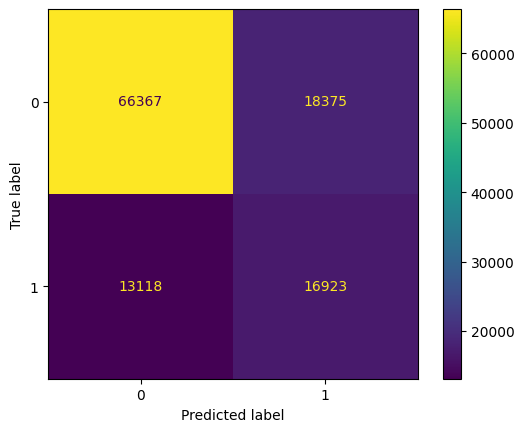

In [9]:
evaluate(model, X_test, y_test)

In [10]:
model.predict(["Lyes dies at the end of the movie"])

array([0])

## Same model but using L1 and liblinear solver

In [11]:
model_l1 = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(penalty='l1', random_state=0, solver='liblinear', class_weight='balanced'))
model_l1.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=0, solver='liblinear'))])

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81     84742
           1       0.48      0.57      0.52     30041

    accuracy                           0.73    114783
   macro avg       0.66      0.68      0.67    114783
weighted avg       0.75      0.73      0.74    114783



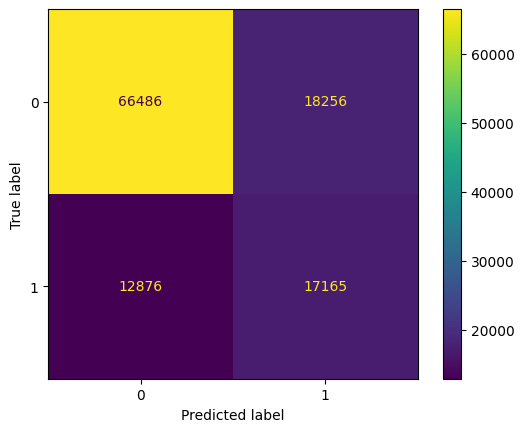

In [12]:
evaluate(model_l1, X_test, y_test)

#### Size comparaison after vs before removing stop words

In [46]:
reviews[reviews['is_spoiler'] == 1]['review_text'].apply(len).mean()

1887.6767313349765

In [47]:
reviews[reviews['is_spoiler'] == 0]['review_text'].apply(len).mean()

1308.154424819558

In [12]:
reviews['review_text'] = reviews['review_text'].apply(remove_stop_words)
reviews[reviews['is_spoiler'] == 1]['review_text'].apply(len).mean()

1287.6493135617927

In [13]:
reviews[reviews['is_spoiler'] == 0]['review_text'].apply(len).mean()

894.9226173730286

## Same model using saga solver with 1000 iterations

In [14]:
X = reviews['review_text']
y = reviews['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(CountVectorizer(ngram_range = (1,1)), LogisticRegression(random_state=0, solver='saga', max_iter=1000))
model.fit(X_train, y_train)

/Users/ilyas/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=0,
                                    solver='saga'))])

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86     84742
           1       0.64      0.33      0.44     30041

    accuracy                           0.78    114783
   macro avg       0.72      0.63      0.65    114783
weighted avg       0.76      0.78      0.75    114783


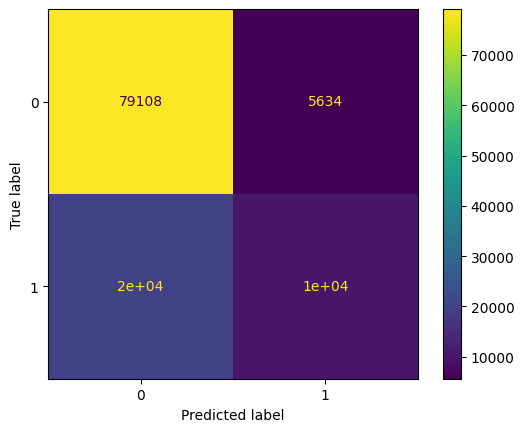

In [15]:
evaluate(model, X_test, y_test)

## Same model but we use tf_idf embedding

In [56]:
X = reviews['review_text']
y = reviews['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=0, class_weight='balanced', max_iter=500))
model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=0))])

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.74      0.80     84742
           1       0.48      0.67      0.56     30041

    accuracy                           0.72    114783
   macro avg       0.67      0.70      0.68    114783
weighted avg       0.76      0.72      0.73    114783


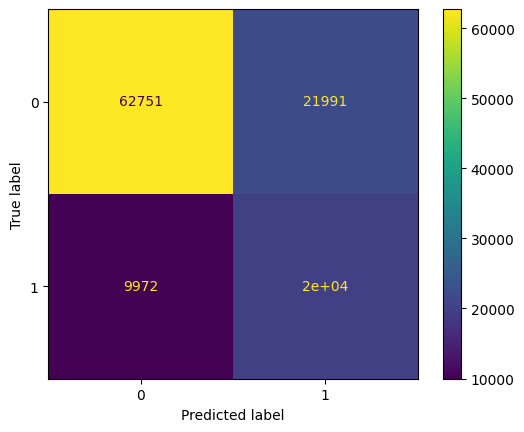

In [57]:
evaluate(model, X_test, y_test)

In [61]:
def prediction(comment):
    if (model.predict([comment])[0] == 1):
        print("Be careful this might be a spoil !")
    else:
        print("This is not a spoil")

In [72]:
comment = "He gets away with murder"

prediction(comment)

Be careful this might be a spoil !


## Startified KFold

In [20]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

texts= reviews['review_text']
labels = reviews['is_spoiler']

pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(random_state=0, class_weight='balanced', max_iter=500))
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
recall_spoiler = make_scorer(recall_score, pos_label=1)
recall_non_spoiler = make_scorer(recall_score, pos_label=0)
precision_spoiler = make_scorer(precision_score, pos_label=1)
precision_non_spoiler = make_scorer(precision_score, pos_label=0)
accuracy = make_scorer(accuracy_score)

# Perform cross-validation and get scores
scores = cross_val_score(pipeline, texts, labels, cv=skf, scoring='accuracy')
recall_spoiler_scores = cross_val_score(pipeline, texts, labels, cv=skf, scoring=recall_spoiler)
recall_non_spoiler_scores = cross_val_score(pipeline, texts, labels, cv=skf, scoring=recall_non_spoiler)
precision_spoiler_scores = cross_val_score(pipeline, texts, labels, cv=skf, scoring=precision_spoiler)
precision_non_spoiler_scores = cross_val_score(pipeline, texts, labels, cv=skf, scoring=precision_non_spoiler)

In [21]:
scores.mean(), recall_spoiler_scores.mean(), recall_non_spoiler_scores.mean(), precision_spoiler_scores.mean(), precision_non_spoiler_scores.mean()

(0.7209768776690524,
 0.6640560584057995,
 0.7412864170853675,
 0.47803483436632915,
 0.8608093343657414)

In [16]:
precision_scores

array([0.76020634, 0.75754117, 0.76109005, 0.76180111, 0.76010994])

## Same model using word2vec embedding
Results are not as good as tf_idf however we can try using other word2vec models or building our own

In [1]:
!pip install gensim

In [9]:
import gensim.downloader as api
wv = api.load("glove-twitter-25")
wv["dies"]

array([-0.21319 , -0.20261 ,  0.78167 ,  0.47846 , -0.21643 , -0.65521 ,
        0.4643  , -0.36891 , -0.29157 ,  0.030099,  0.98732 ,  0.69442 ,
       -2.6999  ,  1.1163  ,  0.5682  ,  0.2118  ,  0.31152 ,  1.0625  ,
       -0.48648 , -1.154   ,  0.96558 ,  0.82259 , -0.10271 , -0.74284 ,
        0.49941 ], dtype=float32)

In [10]:
import numpy as np

def vectorize(review, word2vec):
    words = review.split()
    words = np.array([word for word in words if word in word2vec])
       # Check if there are any valid words
    if words.size > 0:
        res = np.mean(word2vec[words], axis=0)
    else:
        res = np.zeros(word2vec.vector_size)

    return res

In [40]:
reviews_list = reviews['review_text'].tolist()
review_vectors = []
for review in reviews_list:
    res = vectorize(review, wv)
    review_vectors.append(res)

In [45]:
X = review_vectors
y = reviews['is_spoiler'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model_wv = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500)
model_wv.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=0)

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.63      0.71     84742
           1       0.37      0.62      0.47     30041

    accuracy                           0.63    114783
   macro avg       0.60      0.63      0.59    114783
weighted avg       0.71      0.63      0.65    114783


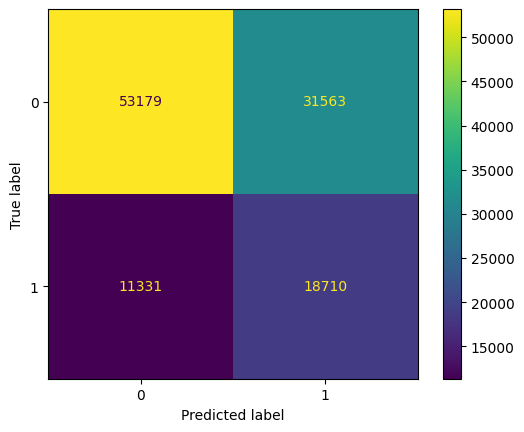

In [51]:
evaluate(model_wv, X_test, y_test)

In [54]:
text = "Lyes dies at the end of the movie"
res = vectorize(text)
model_wv.predict([res])

array([1])

In [13]:
reviews_list = reviews['review_text'].tolist()
review_vectors = []
for review in reviews_list:
    res = vectorize(review, wv50)
    review_vectors.append(res)

In [14]:
X = review_vectors
y = reviews['is_spoiler'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



model_wv = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500)
model_wv.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=500, random_state=0)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.65      0.73     84742
           1       0.40      0.65      0.49     30041

    accuracy                           0.65    114783
   macro avg       0.62      0.65      0.61    114783
weighted avg       0.72      0.65      0.67    114783


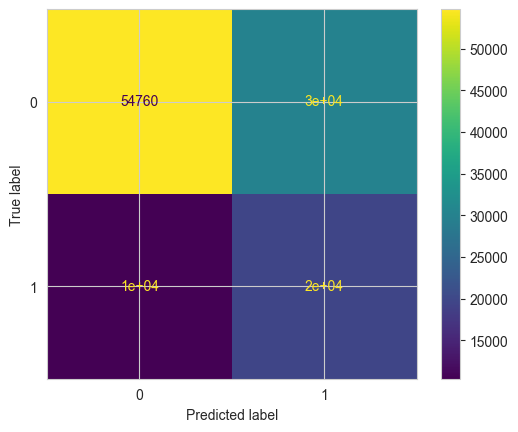

In [15]:
evaluate(model_wv, X_test, y_test)